<a href="https://colab.research.google.com/github/Chuc-ngan/Low-Light-Image-Enhancement/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install opencv-python tqdm

In [ ]:
!pip install tensorflow==2.18.0  # Thay đổi phiên bản theo nhu cầu

# **1. Kết nối với Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/ColabNotebooks/TieuLuan'

!pwd

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1DnsWp1mopgehQJUYpN4ERfnj2CyapJGW/ColabNotebooks/TieuLuan
/content/gdrive/.shortcut-targets-by-id/1DnsWp1mopgehQJUYpN4ERfnj2CyapJGW/ColabNotebooks/TieuLuan


# **2. Import thư viện**

In [ ]:
# ===================== 1. Xử lý dữ liệu =====================
import os
import shutil  # Quản lý tệp/thư mục
import random
import math
import collections
import numpy as np  # Xử lý số học
import pandas as pd  # Xử lý dữ liệu CSV
from pathlib import Path
from PIL import Image, UnidentifiedImageError
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import pickle
# ===================== 2. Machine Learning =====================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns

# ===================== 3. TensorFlow & Keras =====================
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import mixed_precision
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# ===================== 4. Xây dựng mô hình =====================
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation,
    GlobalAveragePooling2D, Dense, Dropout, RepeatVector, Reshape, Flatten
)
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input, decode_predictions
from keras.layers import add, concatenate
from keras import layers, backend as K

# ===================== 5. Xử lý hình ảnh & Vẽ biểu đồ =====================
import cv2 as cv
import matplotlib.pyplot as plt

# ===================== 6. Đặt Seed (Reproducibility) =====================
# tf.random.set_seed(42)  # Thay số 42 bằng giá trị seed mong muốn
# np.random.seed(1)


# **3. Cấu hình môi trường TensorFlow**

In [ ]:
# Thiết lập GPU sử dụng bộ nhớ động (tránh lỗi thiếu bộ nhớ)
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)

# Kiểm tra TensorFlow đang chạy trên GPU hay không
print("TensorFlow is running on GPU:", tf.test.is_built_with_cuda())
# Bật chế độ Mixed Precision để tăng tốc (nếu GPU hỗ trợ)
# Thiết lập mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Bật XLA với cấu hình tối ưu
tf.config.optimizer.set_jit(True)
tf.config.optimizer.set_experimental_options({
    "layout_optimizer": True,
    "constant_folding": True,
    "shape_optimization": True,
    "remapping": True,
    "arithmetic_optimization": True,
    "dependency_optimization": True,
    "loop_optimization": True,
    "function_optimization": True,
    "debug_stripper": True
})

TensorFlow is running on GPU: True


# **4. Configuration**

In [ ]:
# Đường dẫn thư mục gốc chứa ảnh ban đầu
data_dir = "dataset/images"  # Thư mục chứa ảnh gốc

# Thư mục đích cho các tập dữ liệu
train_dir = "dataset/train"  # Thư mục chứa tập huấn luyện
val_dir = "dataset/validation"  # Thư mục chứa tập xác thực
test_dir = "dataset/test"  # Thư mục chứa tập kiểm thử

# Thư mục chứa ảnh thiếu sáng
low_light_dir = "dataset/low_light"  # Thư mục chứa ảnh thiếu sáng không nhiễu
low_light_noise_dir = "dataset/low_light_noise"  # Thư mục chứa ảnh thiếu sáng có nhiễu

# Thư mục chứa ảnh thiếu sáng dùng để huấn luyện cải thiện
low_light_enhance_trainset = "dataset/lowlight_enhance_trainset"  # Thư mục chứa ảnh thiếu sáng để huấn luyện mô hình

# Thư mục chứa ảnh sau khi cải thiện bằng CNN
enhanced_cnn_low_light_dir = "dataset/enhanced_cnn_low_light"  # Thư mục lưu ảnh cải thiện từ ảnh thiếu sáng
enhanced_cnn_low_light_noise_dir = "dataset/enhanced_cnn_low_light_noise"  # Thư mục lưu ảnh cải thiện từ ảnh có nhiễu

# Cấu hình các tham số
SPLIT_RATIO = 0.5  # Tỷ lệ lấy 50% dữ liệu để xử lý
IMG_SIZE = 224  # Kích thước ảnh chuẩn hóa (224x224)
CHANEL = 3  # Số kênh màu (RGB)
BATCH_SIZE = 32  # Kích thước batch khi huấn luyện
EPOCHS = 3  # Số epoch ban đầu (sẽ được điều chỉnh sau)
VAL_SPLIT = 0.2  # Tỷ lệ chia tập xác thực (20%)
RANDOM_SEED = 42  # Hạt ngẫu nhiên để đảm bảo tái lập kết quả

# **5. Hàm ghép cặp ảnh bình thường và ảnh thiếu sáng**

In [ ]:
# Hàm ghép cặp ảnh bình thường và ảnh thiếu sáng
def get_matched_image_pairs(normal_dir, low_light_dir):
    # Hàm nội bộ để tải danh sách đường dẫn ảnh hợp lệ
    def load_image_paths(directory):
        extensions = {".jpg", ".jpeg", ".png", ".bmp"}  # Các định dạng ảnh hợp lệ
        return [os.path.join(root, f)
                for root, _, files in os.walk(directory)
                for f in files
                if os.path.splitext(f.lower())[1] in extensions]  # Lọc file có đuôi hợp lệ

    normal_images = load_image_paths(normal_dir)  # Tải danh sách ảnh bình thường
    low_light_images = load_image_paths(low_light_dir)  # Tải danh sách ảnh thiếu sáng

    # Tạo từ điển ánh xạ tên file (không đuôi) với đường dẫn
    normal_map = {os.path.splitext(os.path.basename(p))[0]: p for p in normal_images}
    low_light_map = {os.path.splitext(os.path.basename(p))[0]: p for p in low_light_images}

    # Tìm các cặp ảnh có tên giống nhau
    common_keys = set(normal_map.keys()) & set(low_light_map.keys())  # Giao của các tên file
    print(f"Found {len(common_keys)} matched image pairs")  # In số cặp ảnh tìm được

    verified_pairs = []  # Danh sách lưu cặp ảnh đã xác minh
    for key in tqdm(common_keys, desc="Verifying image pairs"):  # Duyệt qua từng tên file chung
        try:
            # Đọc ảnh và kiểm tra kích thước (phải là ảnh màu 3 kênh)
            normal_shape = cv.imread(normal_map[key], cv.IMREAD_UNCHANGED).shape
            low_shape = cv.imread(low_light_map[key], cv.IMREAD_UNCHANGED).shape
            if len(normal_shape) == 3 and len(low_shape) == 3:  # Kiểm tra ảnh có 3 kênh
                verified_pairs.append((normal_map[key], low_light_map[key]))  # Thêm cặp hợp lệ
        except:
            continue  # Bỏ qua nếu có lỗi khi đọc ảnh

    print(f"{len(verified_pairs)} pairs passed verification")  # In số cặp ảnh hợp lệ

    if not verified_pairs:
        return [], []  # Trả về danh sách rỗng nếu không có cặp hợp lệ

    return list(zip(*verified_pairs))  # Trả về tuple (normal_images, low_light_images)

In [ ]:
# Hàm lưu cặp ảnh đã xác minh vào file pickle
def save_verified_pairs(pairs, save_path="verified_pairs.pkl"):
    with open(save_path, "wb") as f:
        pickle.dump(pairs, f)  # Lưu cặp ảnh vào file
    print(f"Saved verified pairs to {save_path}")  # In thông báo lưu thành công

In [ ]:
# Load and verify image pairs
normal_images, low_light_images = get_matched_image_pairs(train_dir, low_light_enhance_trainset)

Found 20808 matched image pairs


Verifying image pairs: 100%|██████████| 20808/20808 [3:41:21<00:00,  1.57it/s]

20798 pairs passed verification


In [ ]:
save_verified_pairs((normal_images, low_light_images), save_path="verified_pairs_low_light.pkl")

Saved verified pairs to verified_pairs_low_light.pkl


In [ ]:
# Hàm tải cặp ảnh từ file pickle
def load_verified_pairs(path="verified_pairs.pkl"):
    with open(path, "rb") as f:
        normal_images, low_light_images = pickle.load(f)  # Tải cặp ảnh từ file
    print(f"Loaded {len(normal_images)} verified pairs")  # In số cặp ảnh đã tải
    return normal_images, low_light_images

normal_images, low_light_images = load_verified_pairs("verified_pairs_low_light.pkl")

Loaded 20798 verified pairs


# **6. Show ảnh để kiểm tra**

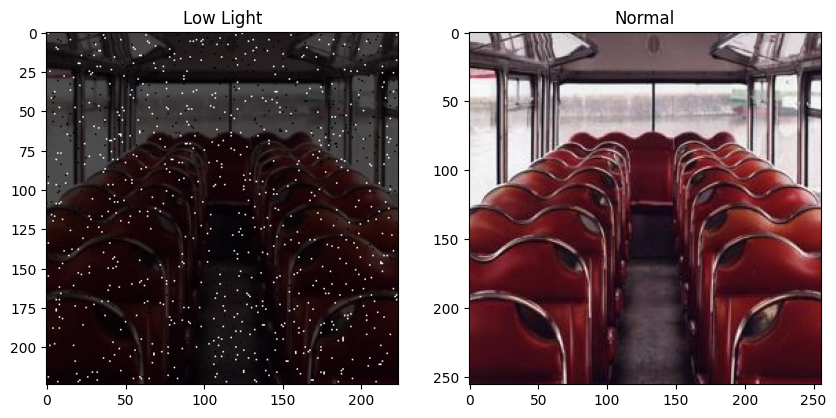

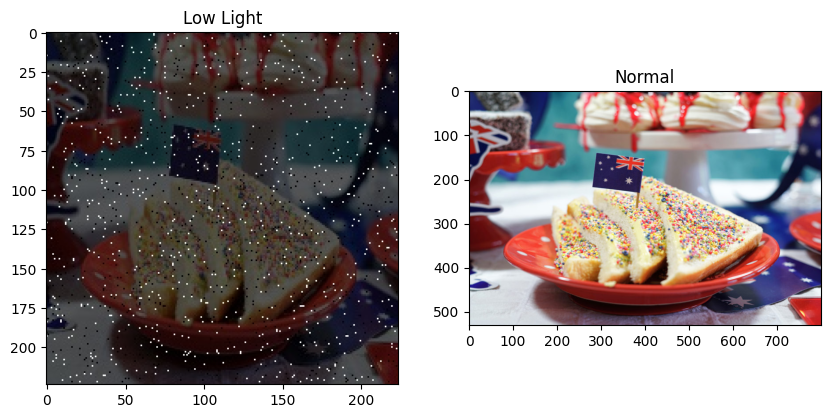

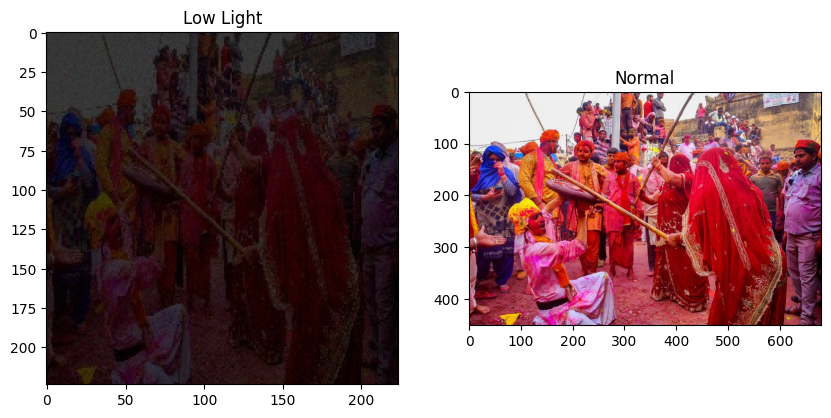

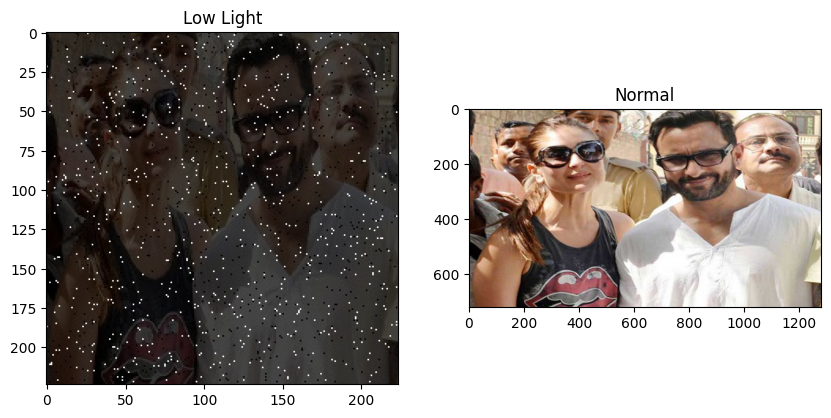

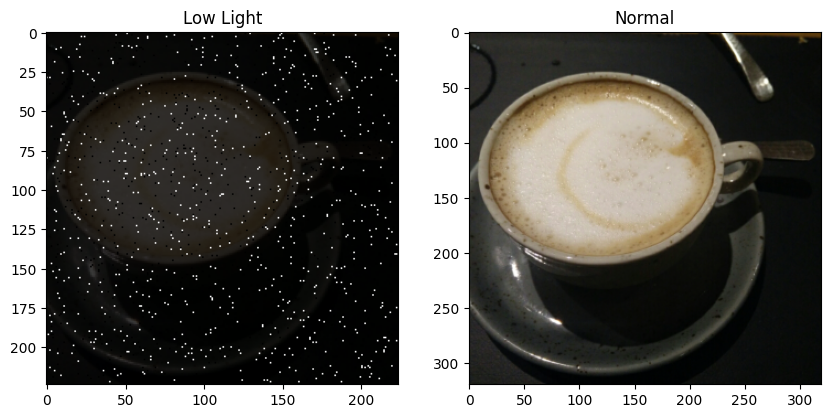

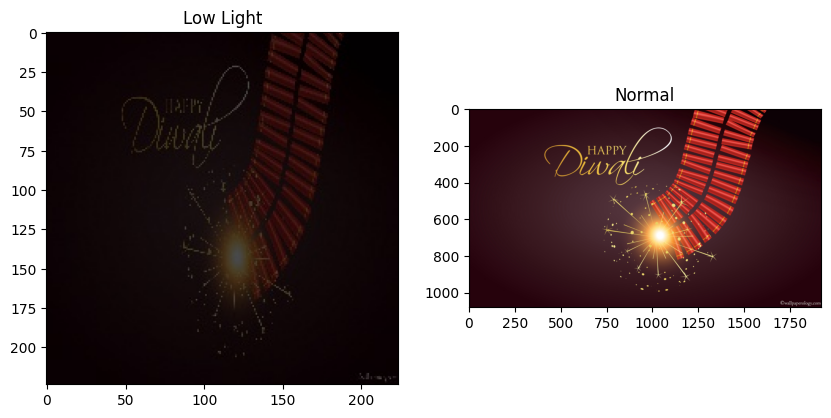

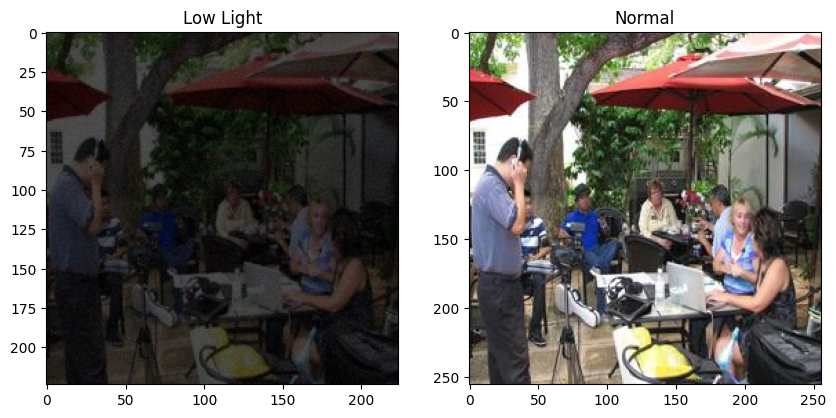

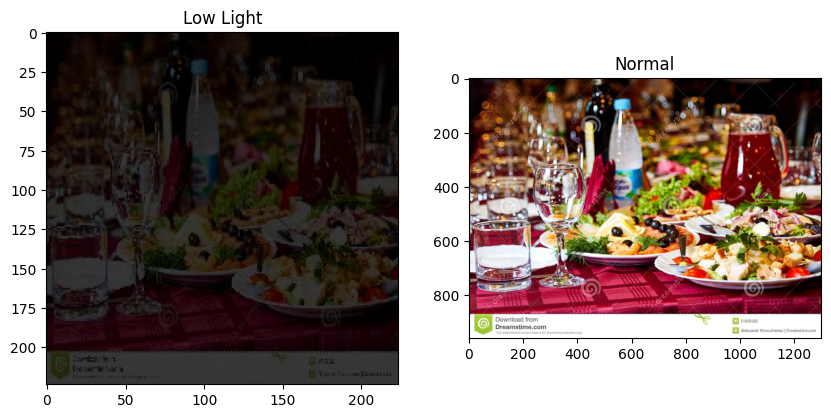

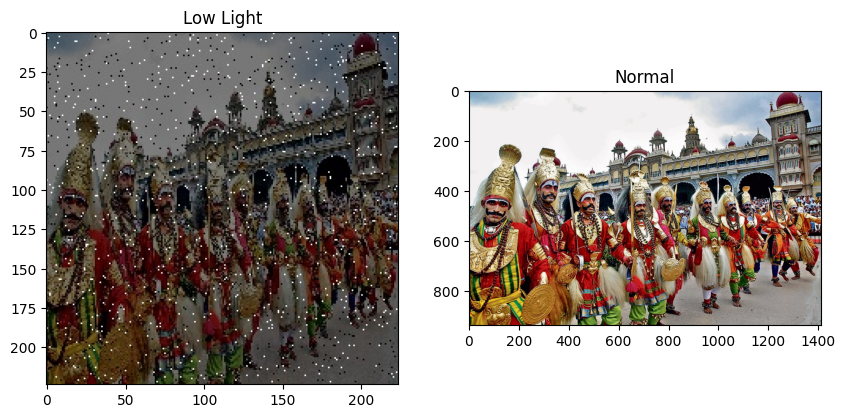

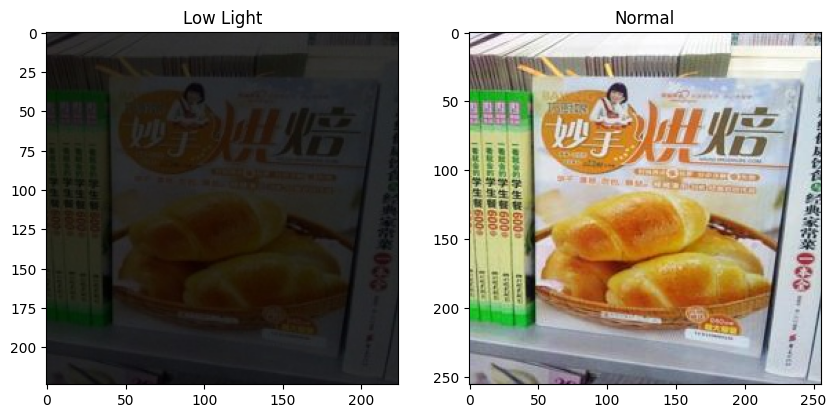

In [ ]:
def display_sample_pair(normal_path, low_path):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(cv.cvtColor(cv.imread(low_path), cv.COLOR_BGR2RGB))
    plt.title("Low Light")

    plt.subplot(1, 2, 2)
    plt.imshow(cv.cvtColor(cv.imread(normal_path), cv.COLOR_BGR2RGB))
    plt.title("Normal")

    plt.show()

# Hiển thị 10 cặp ngẫu nhiên
for i in np.random.choice(len(normal_images), 10):
    display_sample_pair(normal_images[i], low_light_images[i])

# **7. Chia tập huấn luyện và xác thực**

In [ ]:
# Chia tập huấn luyện và xác thực
train_norm, val_norm, train_low, val_low = train_test_split(
    normal_images, low_light_images,
    test_size=VAL_SPLIT  # Chia 20% cho tập xác thực
)

print(f"Training samples: {len(train_norm)}, Validation samples: {len(val_norm)}")

Training samples: 16638, Validation samples: 4160


# **8. Tạo dataset với tf.data**

In [ ]:
# Hàm đọc và tiền xử lý ảnh
def parse_image(normal_path, low_path):
    tf.print("Reading:", normal_path)  # In đường dẫn ảnh để theo dõi
    norm_img = tf.io.read_file(normal_path)  # Đọc ảnh bình thường
    norm_img = tf.image.decode_jpeg(norm_img, channels=3)  # Giải mã ảnh JPEG thành 3 kênh
    norm_img = tf.image.resize(norm_img, [IMG_SIZE, IMG_SIZE])  # Thay đổi kích thước về 224x224
    norm_img = tf.cast(norm_img, tf.float32) / 255.0  # Chuẩn hóa pixel về [0, 1]

    low_img = tf.io.read_file(low_path)  # Đọc ảnh thiếu sáng
    low_img = tf.image.decode_jpeg(low_img, channels=3)  # Giải mã ảnh JPEG thành 3 kênh
    low_img = tf.image.resize(low_img, [IMG_SIZE, IMG_SIZE])  # Thay đổi kích thước về 224x224
    low_img = tf.cast(low_img, tf.float32) / 255.0  # Chuẩn hóa pixel về [0, 1]

    return low_img, norm_img  # Trả về cặp ảnh thiếu sáng và bình thường

# Hàm tạo dataset với tf.data
def create_dataset(normal_images, low_light_images, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((normal_images, low_light_images))  # Tạo dataset từ danh sách đường dẫn
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)  # Áp dụng tiền xử lý ảnh
    dataset = dataset.shuffle(buffer_size=1000)  # Xáo trộn dataset với buffer 1000
    dataset = dataset.batch(batch_size)  # Chia thành các batch
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Tối ưu hóa tải dữ liệu
    return dataset  # Trả về dataset đã xử lý

# Chỉ lấy 100% tập huấn luyện
sample_ratio = 1

train_sample_size = int(len(train_norm) * sample_ratio)
val_sample_size = int(len(val_norm) * sample_ratio)

train_dataset = create_dataset(train_norm[:train_sample_size], train_low[:train_sample_size], BATCH_SIZE)
val_dataset = create_dataset(val_norm[:val_sample_size], val_low[:val_sample_size], BATCH_SIZE)

In [ ]:
print(f"Train samples: {train_sample_size}")
print(f"Val samples: {val_sample_size}")

Train samples: 16638
Val samples: 4160


# **9. Mô hình CNN**

In [ ]:
# Hàm định nghĩa kiến trúc mô hình CNN
def InstantiateModel(in_):
    # Nhánh 1: 3 tầng Conv2D với số bộ lọc tăng dần
    model_1 = Conv2D(16, (3,3), activation='relu', padding='same', strides=1)(in_)  # Tầng Conv2D 16 bộ lọc, kernel 3x3
    model_1 = Conv2D(32, (3,3), activation='relu', padding='same', strides=1)(model_1)  # Tầng Conv2D 32 bộ lọc
    model_1 = Conv2D(64, (2,2), activation='relu', padding='same', strides=1)(model_1)  # Tầng Conv2D 64 bộ lọc, kernel 2x2

    # Nhánh 2: 2 tầng Conv2D
    model_2 = Conv2D(32, (3,3), activation='relu', padding='same', strides=1)(in_)  # Tầng Conv2D 32 bộ lọc
    model_2 = Conv2D(64, (2,2), activation='relu', padding='same', strides=1)(model_2)  # Tầng Conv2D 64 bộ lọc

    # Nhánh 2.0: Thêm tầng Conv2D từ nhánh 2
    model_2_0 = Conv2D(64, (2,2), activation='relu', padding='same', strides=1)(model_2)  # Tầng Conv2D 64 bộ lọc

    # Kết hợp các nhánh bằng phép cộng
    model_add = add([model_1, model_2, model_2_0])  # Gộp đặc trưng từ 3 nhánh

    # Nhánh 3: 3 tầng Conv2D với số bộ lọc giảm dần
    model_3 = Conv2D(64, (3,3), activation='relu', padding='same', strides=1)(model_add)  # Tầng Conv2D 64 bộ lọc
    model_3 = Conv2D(32, (3,3), activation='relu', padding='same', strides=1)(model_3)  # Tầng Conv2D 32 bộ lọc
    model_3 = Conv2D(16, (2,2), activation='relu', padding='same', strides=1)(model_3)  # Tầng Conv2D 16 bộ lọc

    # Nhánh 3.1: 2 tầng Conv2D từ model_add
    model_3_1 = Conv2D(32, (3,3), activation='relu', padding='same', strides=1)(model_add)  # Tầng Conv2D 32 bộ lọc
    model_3_1 = Conv2D(16, (2,2), activation='relu', padding='same', strides=1)(model_3_1)  # Tầng Conv2D 16 bộ lọc

    # Nhánh 3.2: Tầng Conv2D từ model_add
    model_3_2 = Conv2D(16, (2,2), activation='relu', padding='same', strides=1)(model_add)  # Tầng Conv2D 16 bộ lọc

    # Kết hợp các nhánh 3
    model_add_2 = add([model_3_1, model_3_2, model_3])  # Gộp đặc trưng từ 3 nhánh

    # Nhánh 4: Tầng Conv2D từ model_add_2
    model_4 = Conv2D(16, (3,3), activation='relu', padding='same', strides=1)(model_add_2)  # Tầng Conv2D 16 bộ lọc
    model_4_1 = Conv2D(16, (3,3), activation='relu', padding='same', strides=1)(model_add)  # Tầng Conv2D 16 bộ lọc từ model_add

    # Kết hợp nhánh 4 và các nhánh trước
    model_add_3 = add([model_4_1, model_add_2, model_4])  # Gộp đặc trưng từ 3 nhánh

    # Nhánh cuối: 2 tầng Conv2D để tạo đầu ra
    model_5 = Conv2D(16, (3,3), activation='relu', padding='same', strides=1)(model_add_3)  # Tầng Conv2D 16 bộ lọc
    model_5 = Conv2D(16, (2,2), activation='relu', padding='same', strides=1)(model_add_3)  # Tầng Conv2D 16 bộ lọc

    # Tầng cuối xuất ra 3 kênh (RGB)
    model_5 = Conv2D(3, (3,3), activation='relu', padding='same', strides=1)(model_5)  # Tầng Conv2D 3 kênh, ReLU

    return model_5  # Trả về đầu ra mô hình

In [ ]:
Input_Sample = Input(shape=(IMG_SIZE, IMG_SIZE, CHANEL))
Output_ = InstantiateModel(Input_Sample)
Model_Enhancer = Model(inputs=Input_Sample, outputs=Output_)

Model_Enhancer.compile(optimizer="adam", loss='mean_squared_error')
Model_Enhancer.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_1 (Cast)       │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        448 │ cast[0][0]        │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 224, 224,  │        896 │ cast_1[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      4,640 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 224, 224,  │      8,256 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 224, 224,  │      8,256 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 224, 224,  │     16,448 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ conv2d_2[0][0],   │
│                     │ 64)               │            │ conv2d_4[0][0],   │
│                     │                   │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 224, 224,  │     36,928 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 224, 224,  │     18,464 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 224, 224,  │     18,464 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 224, 224,  │      2,064 │ conv2d_9[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 224, 224,  │      4,112 │ add[0][0]         │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 224, 224,  │      2,064 │ conv2d_7[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 134,067 (523.70 KB)

 Trainable params: 134,067 (523.70 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callback để lưu trọng số tốt nhất
checkpoint = ModelCheckpoint(
    'model/model_enhance_with_cnn.weights.h5',  # Đường dẫn lưu trọng số
    monitor='val_loss',  # Theo dõi mất mát trên tập xác thực
    save_best_only=True,  # Chỉ lưu khi mất mát tốt nhất
    save_weights_only=True,  # Chỉ lưu trọng số
    mode='min',  # Tìm giá trị mất mát nhỏ nhất
    verbose=1  # Hiển thị thông báo khi lưu
)

# Callback để dừng sớm nếu không cải thiện
early_stop = EarlyStopping(
    monitor='val_loss',  # Theo dõi mất mát trên tập xác thực
    patience=5,  # Dừng sau 5 epoch nếu không cải thiện
    restore_best_weights=True,  # Khôi phục trọng số tốt nhất
    verbose=1  # Hiển thị thông báo khi dừng
)

# Callback để giảm learning rate khi không cải thiện
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Theo dõi mất mát trên tập xác thực
    factor=0.5,  # Giảm learning rate xuống 50%
    patience=2,  # Chờ 2 epoch trước khi giảm
    min_lr=1e-5,  # Learning rate tối thiểu
    verbose=1  # Hiển thị thông báo khi giảm
)

# Huấn luyện mô hình từng phần để tránh ngắt kết nối
total_epochs = 10  # Tổng số epoch huấn luyện
epochs_per_fit = 2  # Số epoch mỗi lần huấn luyện
for epoch in range(0, total_epochs, epochs_per_fit):  # Huấn luyện theo từng giai đoạn
    Model_Enhancer.fit(
        train_dataset,  # Tập huấn luyện
        validation_data=val_dataset,  # Tập xác thực
        epochs=min(epoch + epochs_per_fit, total_epochs),  # Số epoch cho giai đoạn hiện tại
        initial_epoch=epoch,  # Epoch bắt đầu
        verbose=1,  # Hiển thị tiến trình huấn luyện
        shuffle=True,  # Xáo trộn dữ liệu
        callbacks=[checkpoint, early_stop, reduce_lr]  # Sử dụng các callback
    )

Epoch 1/2
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0551
Epoch 1: val_loss improved from inf to 0.01354, saving model to model/model_enhance_with_cnn.weights.h5
208/208 ━━━━━━━━━━━━━━━━━━━━ 2530s 11s/step - loss: 0.0550 - val_loss: 0.0135 - learning_rate: 0.0010
Epoch 2/2
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.0128
Epoch 2: val_loss improved from 0.01354 to 0.01123, saving model to model/model_enhance_with_cnn.weights.h5
208/208 ━━━━━━━━━━━━━━━━━━━━ 83s 291ms/step - loss: 0.0128 - val_loss: 0.0112 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 2.
Epoch 3/4
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.0119
Epoch 3: val_loss improved from 0.01123 to 0.01079, saving model to model/model_enhance_with_cnn.weights.h5
208/208 ━━━━━━━━━━━━━━━━━━━━ 67s 290ms/step - loss: 0.0119 - val_loss: 0.0108 - learning_rate: 0.0010
Epoch 4/4
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.0112
Epoch 4: val_loss did not improve from 0.01079

In [ ]:
# Load lại mô hình đã lưu
model_path = "model/model_enhance_with_cnn.weights.h5"  # Đường dẫn file weights
model = Model_Enhancer  # Sử dụng kiến trúc đã có
model.load_weights(model_path)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 70 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 66 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# **10. Cải thiện bằng CNN**

In [ ]:
# Hàm cải thiện ảnh bằng CNN
def enhance_images(input_dir, output_dir, model, img_size=(224, 224)):
    all_images = []  # Danh sách lưu cặp đường dẫn ảnh đầu vào và thư mục đầu ra

    # Duyệt qua toàn bộ cấu trúc thư mục
    for root, dirs, files in os.walk(input_dir):  # Duyệt qua thư mục đầu vào
        relative_path = os.path.relpath(root, input_dir)  # Tính đường dẫn tương đối
        target_dir = os.path.join(output_dir, relative_path)  # Tạo thư mục đầu ra tương ứng
        os.makedirs(target_dir, exist_ok=True)  # Tạo thư mục nếu chưa tồn tại

        # Lọc các file ảnh hợp lệ
        image_paths = [os.path.join(root, f) for f in files if f.endswith((".jpg", ".png", ".jpeg"))]
        all_images.extend([(img_path, target_dir) for img_path in image_paths])  # Thêm cặp (đường dẫn ảnh, thư mục đích)

    # Xử lý từng ảnh với thanh tiến trình
    with tqdm(total=len(all_images), desc="Enhancing images", dynamic_ncols=True, leave=True) as pbar:
        for img_path, target_dir in all_images:  # Duyệt qua từng cặp ảnh
            img = cv.imread(img_path)  # Đọc ảnh đầu vào
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # Chuyển từ BGR sang RGB
            img = cv.resize(img, img_size)  # Thay đổi kích thước về 224x224

            img = img.astype(np.float32) / 255.0  # Chuẩn hóa pixel về [0, 1]
            img = np.expand_dims(img, axis=0)  # Mở rộng chiều batch cho dự đoán

            # Dự đoán ảnh cải thiện bằng mô hình CNN
            enhanced_img = model.predict(img, verbose=0)[0]  # Dự đoán và lấy đầu ra
            enhanced_img = (enhanced_img * 255).astype(np.uint8)  # Chuyển giá trị pixel về [0, 255]

            # Lưu ảnh cải thiện
            output_path = os.path.join(target_dir, os.path.basename(img_path))  # Tạo đường dẫn lưu
            cv.imwrite(output_path, cv.cvtColor(enhanced_img, cv.COLOR_RGB2BGR))  # Chuyển về BGR và lưu ảnh

            pbar.update(1)  # Cập nhật thanh tiến độ

    print(f"✅ Đã lưu {len(all_images)} ảnh cải thiện vào {output_dir}")  # In thông báo hoàn thành

In [ ]:
# Gọi hàm tăng cường ảnh
enhance_images(low_light_dir, enhanced_cnn_low_light_dir, Model_Enhancer)

In [ ]:
enhance_images(low_light_noise_dir, enhanced_cnn_low_light_noise_dir, Model_Enhancer)

Enhancing images: 100%|██████████| 10370/10370 [1:07:41<00:00,  2.55it/s]

✅ Đã lưu 10370 ảnh cải thiện vào dataset/enhanced_cnn_low_light_noise
